In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

# TensorFlow Eager NN Automatic Differentiation

This notebook walks through the process of constructing a feed-forward neural network for multi-class classification using TensorFlow's eager execution. This notebook should look most nearly identical to the NumPy representation, but with automatic gradient calculations. Eager execution is easiest to use from a Python background, but it is painfully slow.

## Layers

For our neural network, we want to abstract away from individual neurons and focus on layers. Each element of the network will be defined by a certain layer.

### Base Layer

This layer provides the virtual methods that each layer has to implement. If the layer doesn't implement the method, we default to one of these empty methods.

In [2]:
class Layer:
    """Abstract base layer for our neural network."""

The `__init__` method sets up constant information about the layer that is necessary to build the graph later. Typically, only dimensions of input/output data is required.

In [3]:
    def __init__(self):
        """Initializes layer constants necessary to construct the graph
            for training. Likely: just dimension information or nothing
            at all."""

Layer.__init__ = __init__

The forward method computes the forward pass from the network. All layers should implement this method.

In [4]:
    def forward(self, X):
        """Executes the forward pass through the layer
            
        Args:
            X (ndarray): A matrix representing the inputs to the layer.
                Likely: A or Z depending on the layer.
        
        Returns:
            ndarray: A tensor representing the outputs of the layer. 
                Likely: Z or A depending on the layer.
                
        """

Layer.forward = forward

The backward method computes the backward pass step for a single layer. This should be implemented for all layers.

In [5]:
    def backward(self, dL):
        """Computes the backward pass for the layer.
            
        Args:
            dL (ndarray): A matrix representing the gradient of the loss
                of the network with respect to the outputs of the current
                layer. Likely: dLdA or dLdZ depending on the layer.
        
        Returns:
            ndarray: A matrix representing the gradient of the loss of the
                network will respect to the inputs of the current layer.
                Likely: dLdZ or dLdA depending on the layer.
        
        """

Layer.backward = backward

Any layer that has any variables needs to update these variables during stochastic gradient descent.

In [6]:
    def sgd_step(self, eta):
        """Updates trainable variables based off the results from the
            backward pass.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
                
        """

Layer.sgd_step = sgd_step

### Linear Layer

This is the simplest possible layer where all inputs are connected to all outputs.

In [7]:
class Linear(Layer):
    """Simple layer fully-connecting inputs to outputs linearly."""

To set up this layer, we need to know the input and output dimensions ahead of time. Using this information, we randomly initialize the weight matrices.

In [8]:
    def __init__(self, m, n):
        """Initializes the layer based on input and output dimensions. 

        Note: Kernel is initialized using normal distribution with mean 0 
        and variance 1 / m. All biases are initialized to zero.

        Args:
            m (int): Number of input features to the layer.
            n (int): Number of output features of the layer.

        """
        self.m = m
        self.n = n

        self.W0 = tf.Variable(initial_value=tf.zeros(shape=(self.n, 1)))
        self.W = tf.Variable(initial_value=tf.random.normal(shape=(self.m, self.n), mean=0.0, stddev=tf.sqrt(1 / self.m)))
                
Linear.__init__ = __init__

With our variables defined, we can execute the forward pass. We take the activation $A$ from the previous layer and produce the current $Z$ pre-activation.

In [9]:
    def forward(self, A):
        """Computes the forward pass of the layer.
            
        Args:
            A (ndarray): An m by b matrix representing the activations from
                the previous layer with a batch of size b.
                
        Returns:
            ndarray: An n by b matrix, Z, representing the pre-activations
                as the output from this linear layer.
        
        """
        # We need these later when computing the backward path.
        self.A = A
        self.Z = tf.transpose(self.W) @ self.A + self.W0
        
        return self.Z

Linear.forward = forward

For now, we will compute the gradients by hand using back-propogation. We take the gradient of the loss with respect to the pre-activations of the layer $\partial \mathrm{Loss} / \partial Z$ and compute the gradient of the loss with respect to the activations of the previous layer $\partial \mathrm{Loss} / \partial A$. 

In addition, we save gradients of the loss with respect to the weights ($\partial \mathrm{Loss} / \partial W$ and $\partial \mathrm{Loss} / \partial W_0$) for the stochastic gradient descent update step.

In [10]:
    def backward(self, gradient_tape, dLdZ):
        """Computes the backward pass for the layer. Also records gradients
            of the loss with respect to weights for later stochastic 
            gradient descent updates.
        
        Args:
            dLdZ (ndarray): An n by b matrix representing the gradient of
                the loss with respect to the current layer's 
                pre-activations for a batch of size b.
                
        Returns:
            ndarray: An m by b matrix, dLdA, representing the gradient of 
                the loss with respect to the previous layer's activations.
        
        """
        # We store these gradients for use later in the sgd_step
        self.dLdW, self.dLdW0 = gradient_tape.gradient(self.Z, [self.W, self.W0], dLdZ)

        return gradient_tape.gradient(self.Z, self.A, dLdZ)

Linear.backward = backward

The linear layer has some trainable parameters to update. Using the specified learning rate $\eta$, we can re-assign our variable values using stochastic gradient descent.

In [11]:
    def sgd_step(self, eta):
        """Updates the layer's variables using stochastic gradient
            descent.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
        
        """
        self.W.assign_sub(eta * self.dLdW)
        self.W0.assign_sub(eta * self.dLdW0)
        
Linear.sgd_step = sgd_step

### Rectified Linear Unit Activation Layer

This layer applies the relu activation function to each of the inputs element-wise.

In [12]:
class ReLU(Layer):
    """Applies relu activation function to all inputs."""

We have no variables to consider, we just need to construct the forward and backward passes. With the forward pass we compute the activation $A$ using the previous layer's pre-activation $A$.

In [13]:
    def forward(self, Z):
        """Compute the forward pass output for the layer. 
            
        Args:
            Z (ndarray): An m by b matrix representing the pre-activations
                from the previous layer for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix, A, representing the activations from
                the current layer for a batch of size b. (Note: n and m 
                are equal.)
                
        """
        # We need these when computing the backward step later
        self.Z = Z
        self.A = tf.maximum(0.0, self.Z)
        
        return self.A
    
ReLU.forward = forward

In the backward pass, we use the gradient of the loss with respect to the layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [14]:
    def backward(self, gradient_tape, dLdA):
        """Computes the backward pass for the layer.
        
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of
                the loss with respect to the current layer's activations
                for a batch of size b.
        
        Returns:
            ndarray: An m by b matrix, dLdZ, representing the gradient of
                the loss with respect to the previous layer's activations
                for a batch of size b. (Note: n and m are equal.)
        
        """
        return gradient_tape.gradient(self.A, self.Z, dLdA)
    
ReLU.backward = backward

### Hyperbolic Tangent Activation Layer

This layer applies the hyperbolic tangent activation function to each input element-wise.

In [15]:
class Tanh(Layer):
    """Applies hyperbolic tangent activation function to all inputs."""

There are no variables in this layer, thus we only need to worry about forward and backward passes. The forward pass takes the previous layer's pre-activation $Z$ and produces the activation $A$.

In [16]:
    def forward(self, Z):
        """Computes the forward pass activation for the layer.
        
        Args:
            Z (ndarray): An m by b matrix representing the previous layer's
                pre-activation for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix, A, representing the layer's 
                activation for a batch of size b. (Note: m and n are
                equal.)
                
        """
        # We need these when computing the backward step later
        self.Z = Z
        self.A = tf.tanh(self.Z)
        
        return self.A

Tanh.forward = forward

The backward pass uses the gradient of the loss with respect to the layer's activation $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activation $\partial \mathrm{Loss} / \partial Z$.

In [17]:
    def backward(self, gradient_tape, dLdA):
        """Computes the backward pass for the layer.
        
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of
                the loss with respect to this layer's activation for a 
                batch of size b.
                
        Returns:
            ndarray: An m by b matrix, dLdZ, representing the gradient of 
                the loss with respect to the previous layer's 
                pre-activation for a batch of size b. (Note: n and m are 
                equal.)
                
        """
        return gradient_tape.gradient(self.A, self.Z, dLdA)
Tanh.backward = backward

### Softmax Activation Layer

This layer applies the softmax activation function to the inputs.

In [18]:
class SoftMax(Layer):
    """Applies the softmax activation function to layer inputs."""

As with the other activation layers, there are no variables to consider. The forward pass takes the previous layer's pre-activations $Z$ and computes the current layer's activation $A$.

In [19]:
    def forward(self, Z):
        """Computes the forward pass activations for the layer.
            
        Args:
            Z (ndarray): An m by b matrix representing the previous layer's
                pre-activation for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix, A, representing the current layer's
                activation for a batch of size b. (Note: m and n are
                equal.)
                
        """
        # We need this activation when computing the backward step later
        self.Z = Z
        self.A = tf.exp(self.Z) / tf.reduce_sum(tf.exp(self.Z), axis=0, keepdims=True)
        
        return self.A

SoftMax.forward = forward

In the backward pass, we use the gradient of the loss with respect to the current layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [20]:
    def backward(self, gradient_tape, dLdA):
        """Computes the backward pass for the layer.
            
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of
                the loss with respect to the current layer's activation.
                
        Returns:
            ndarray: An m by b tensor, dLdZ, representing the gradient of 
                the loss with respect to the previous layer's 
                pre-activation. (Note: n and m are equal.)
            
        """
        return gradient_tape.gradient(self.A, self.Z, dLdA)
        
SoftMax.backward = backward

### Negative Log-Likelihood Multi-Class Loss Layer

This layer computes the loss of the output of the network compared with the expected results.

In [21]:
class NLLM(Layer):
    """Computes the negative log-likelihood multi-class loss for neural
        network outputs and expected outputs."""

Like the activation layers, there are no variables to consider. The forward pass takes the neural network's final activations $A$ and the expected outputs
$Y$ and computes the loss scalar.

In [22]:
    def forward(self, A, Y):
        """Computes the loss of predictions vs expected outputs.
            
        Args:
            A (ndarray): An n by b matrix representing the neural network's
                outputs for a batch of size b.
            Y (ndarray): An n by b matrix representing the expected outputs
                from the neural network for a batch of size b.
        
        Returns:
            float: A scalar, L, which represents the loss of the neural
                network for a batch of size b.
        
        """
        # We will need both of these later to compute the backward pass.
        self.A = A
        self.Y = Y
        self.L = -tf.reduce_sum(self.Y * tf.math.log(self.A))
        
        return self.L

NLLM.forward = forward

The backward pass computes the gradient of the loss with respect to the neural network's final activations $\partial \mathrm{Loss} / \partial A$. Note, this is not immediately computing $\partial \mathrm{Loss} / \partial Z$ by assuming softmax activations.

In [23]:
    def backward(self, gradient_tape):
        """Computes the backward step for the loss.
        
        Returns:
            Tensor: An n by b tensor, dLdA, representing the gradient of
                the loss with respect to the neural network's outputs.
                
        """
        return gradient_tape.gradient(self.L, self.A)

NLLM.backward = backward

## Model

Now we have all the components to construct our neural network, but we need a model to connect them together.

### Sequential Model

The sequential model simply connects all the layer linearly.

In [24]:
class Sequential:
    """A standard neural network model with linearly stacked layers."""

The first step to construct the model is to provide a list of layers.

In [25]:
    def __init__(self, layers, loss):
        """Initialize the layers and the loss for the network.
        
        Args:
            layers (list of Layer): A list of layers in sequential order
                to construct the model from.
            loss (Layer): A layer used to construct the objective for
                stochastic gradient descent.
        
        """
        self.layers = layers
        self.loss = loss

Sequential.__init__ = __init__

To make predictions with the network, we use the `forward` method. This passes the data through every layer and returns the result.

In [26]:
    def forward(self, X):
        """Predicts the output for a training input batch.
        
        Args:
            X (ndarray): A d by b matrix of points to predict with 
                dimension d and batch size b.
        
        Returns:
            ndarray: A c by b matrix representing the predicted outputs 
                with c features of the neural network for a batch size b.
        
        """
        for layer in self.layers:
            X = layer.forward(X)
            
        return X

Sequential.forward = forward

To train the network, we will use stochastic gradient descent. Before we define the stochastic gradient descent training loop, we have to back-propogate the error throughout the layers of the network. To do this, we use the `backward` method.

In [27]:
    def backward(self, gradient_tape, dL):
        """Computes the gradients of the loss with respect to each weight
        in the neural network to prepare for stochastic gradient descent.
        
        Args:
            dL (ndarray): An n by b tensor representing the gradient of the
                loss with respect to the output of the neural network.
        
        """
        for layer in self.layers[::-1]:
            dL = layer.backward(gradient_tape, dL)

Sequential.backward = backward

Once the error is propogated through all the layers, each layer can update their weight matrices. For a single step, this is achieved through the `sgd_step` method.

In [28]:
    def sgd_step(self, eta):
        """Runs a single update step on the weight matrices throughout the
        neural network using stochastic gradient descent.
        
        Args:
            eta (float): A learning rate for stochastic gradient descent.
        
        """
        for layer in self.layers:
            layer.sgd_step(eta)

Sequential.sgd_step = sgd_step

Now we loop over the data applying many stochastic gradient descent update steps.

In [29]:
    def sgd(self, X_train, Y_train, epochs, eta):
        """Trains the neural network by running stochastic gradient descent.
        
        Args:
            X_train (ndarray): A d by n NumPy array representing n input
                training points each with d features.
            Y_train (ndarray): A c by n NumPy array representing n output
                training points each with c features.
            epochs (int): Number of iterations to run stochastic gradient
                descent.
            eta (float): A learning rate for stochastic gradient descent.
        
        """
        _, n = X.shape
        
        for epoch in range(epochs):
            
            t = np.random.randint(n)
            
            Xt = tf.convert_to_tensor(X[:, t:t + 1])
            Yt = tf.convert_to_tensor(Y[:, t:t + 1])
            
            with tf.GradientTape(persistent=True) as gradient_tape:
                loss = self.loss.forward(self.forward(Xt), Yt)
            self.backward(gradient_tape, self.loss.backward(gradient_tape))            
            self.sgd_step(eta)
            
            if epoch % 250 == 1:
                
                acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.forward(X_train), axis=0), tf.argmax(Y_train, axis=0)), tf.float32))
                print('Iteration =', epoch, '\tAcc =', acc.numpy(), '\tLoss =', loss.numpy(), flush=True)

Sequential.sgd = sgd

## Training

Our model is complete! Let's train it on some data and see how will it can classify. We will use the standard 'hard' data set used previously.

In [30]:
X = np.array([[-0.23390341,  1.18151883, -2.46493986,  1.55322202,  1.27621763,
                2.39710997, -1.34403040, -0.46903436, -0.64673502, -1.44029872,
               -1.37537243,  1.05994811, -0.93311512,  1.02735575, -0.84138778,
               -2.22585412, -0.42591102,  1.03561105,  0.91125595, -2.26550369],
              [-0.92254932, -1.10309630, -2.41956036, -1.15509002, -1.04805327,
                0.08717325,  0.81847250, -0.75171045,  0.60664705,  0.80410947,
               -0.11600488,  1.03747218, -0.67210575,  0.99944446, -0.65559838,
               -0.40744784, -0.58367642,  1.05972780, -0.95991874, -1.41720255]], dtype=np.float32)

Y = np.array([[0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
              [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.]], dtype=np.float32)

Let's start by taking a look at our data.

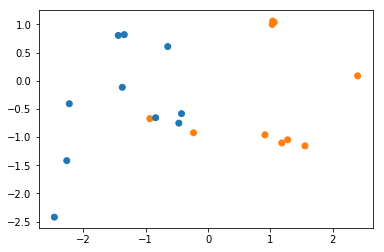

In [31]:
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))

Now we can construct a neural network we think might be able to classify these points.

In [32]:
model = Sequential([Linear(2, 10), ReLU(), 
                    Linear(10, 10), ReLU(), 
                    Linear(10, 2), SoftMax()], NLLM())

Let's try training the model on the data for a few thousand iterations.

In [33]:
model.sgd(X, Y, 100000, 0.005)

Iteration = 1 	Acc = 0.25 	Loss = 0.9410402
Iteration = 251 	Acc = 0.9 	Loss = 0.57954
Iteration = 501 	Acc = 0.9 	Loss = 1.447955
Iteration = 751 	Acc = 0.9 	Loss = 0.075937405
Iteration = 1001 	Acc = 0.95 	Loss = 0.12638488
Iteration = 1251 	Acc = 0.95 	Loss = 0.0027685903
Iteration = 1501 	Acc = 0.95 	Loss = 0.003746665
Iteration = 1751 	Acc = 0.95 	Loss = 0.0021606167
Iteration = 2001 	Acc = 0.95 	Loss = 0.008674887
Iteration = 2251 	Acc = 0.95 	Loss = 0.011993518
Iteration = 2501 	Acc = 0.95 	Loss = 0.0012499153
Iteration = 2751 	Acc = 0.95 	Loss = 0.00086517795
Iteration = 3001 	Acc = 0.95 	Loss = 0.01638822
Iteration = 3251 	Acc = 0.95 	Loss = 0.24862334
Iteration = 3501 	Acc = 0.95 	Loss = 0.02234308
Iteration = 3751 	Acc = 0.95 	Loss = 0.03711169
Iteration = 4001 	Acc = 0.95 	Loss = 0.5959203
Iteration = 4251 	Acc = 0.95 	Loss = 0.0004961529
Iteration = 4501 	Acc = 0.95 	Loss = 0.17424287
Iteration = 4751 	Acc = 0.95 	Loss = 0.0023092448
Iteration = 5001 	Acc = 0.95 	Loss = 0.

Iteration = 42001 	Acc = 1.0 	Loss = -0.0
Iteration = 42251 	Acc = 1.0 	Loss = -0.0
Iteration = 42501 	Acc = 1.0 	Loss = 0.0059868135
Iteration = 42751 	Acc = 0.95 	Loss = 1.1324889e-06
Iteration = 43001 	Acc = 1.0 	Loss = 0.50469184
Iteration = 43251 	Acc = 1.0 	Loss = 1.4305125e-06
Iteration = 43501 	Acc = 1.0 	Loss = 2.0861648e-06
Iteration = 43751 	Acc = 1.0 	Loss = 0.0024366835
Iteration = 44001 	Acc = 1.0 	Loss = 0.003281189
Iteration = 44251 	Acc = 1.0 	Loss = 0.003804042
Iteration = 44501 	Acc = 0.95 	Loss = 0.00284211
Iteration = 44751 	Acc = 1.0 	Loss = 0.638136
Iteration = 45001 	Acc = 1.0 	Loss = 4.768373e-07
Iteration = 45251 	Acc = 1.0 	Loss = -0.0
Iteration = 45501 	Acc = 0.95 	Loss = -0.0
Iteration = 45751 	Acc = 1.0 	Loss = -0.0
Iteration = 46001 	Acc = 0.95 	Loss = 0.00013590783
Iteration = 46251 	Acc = 1.0 	Loss = 1.549722e-06
Iteration = 46501 	Acc = 0.95 	Loss = 5.36442e-07
Iteration = 46751 	Acc = 1.0 	Loss = 6.556513e-07
Iteration = 47001 	Acc = 1.0 	Loss = 0.000

Iteration = 85001 	Acc = 1.0 	Loss = 2.9802328e-07
Iteration = 85251 	Acc = 1.0 	Loss = 0.00034439532
Iteration = 85501 	Acc = 1.0 	Loss = 0.00031023068
Iteration = 85751 	Acc = 1.0 	Loss = 0.00042322293
Iteration = 86001 	Acc = 1.0 	Loss = -0.0
Iteration = 86251 	Acc = 1.0 	Loss = 0.004303643
Iteration = 86501 	Acc = 1.0 	Loss = 1.4901173e-06
Iteration = 86751 	Acc = 1.0 	Loss = 0.0012643578
Iteration = 87001 	Acc = 1.0 	Loss = 2.9802328e-07
Iteration = 87251 	Acc = 1.0 	Loss = -0.0
Iteration = 87501 	Acc = 1.0 	Loss = 0.08409069
Iteration = 87751 	Acc = 1.0 	Loss = -0.0
Iteration = 88001 	Acc = 1.0 	Loss = 0.0009994732
Iteration = 88251 	Acc = 1.0 	Loss = 9.6444965e-05
Iteration = 88501 	Acc = 1.0 	Loss = 0.0009721473
Iteration = 88751 	Acc = 1.0 	Loss = -0.0
Iteration = 89001 	Acc = 1.0 	Loss = 1.4901173e-06
Iteration = 89251 	Acc = 1.0 	Loss = -0.0
Iteration = 89501 	Acc = 1.0 	Loss = -0.0
Iteration = 89751 	Acc = 1.0 	Loss = -0.0
Iteration = 90001 	Acc = 1.0 	Loss = -0.0
Iteration

Seems like it has fitted the data 100\%. Let's see what the decision boundary looks like.

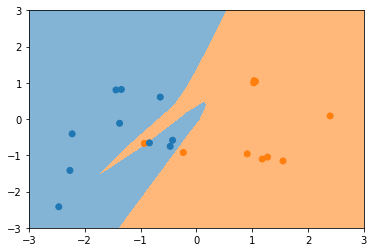

In [34]:
# Create a grid of points to classify
xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.005), np.arange(-3, 3, 0.005))

# Flatten the grid to pass into model
grid = np.c_[xx1.ravel(), xx2.ravel()].T

# Predict classification at every point on the grid
Z = model.forward(grid)[1,:].numpy().reshape(xx1.shape)

# Plot the prediction regions.
plt.imshow(Z, interpolation='bicubic', origin='lower', extent=[-3, 3, -3, 3], 
           cmap=ListedColormap(['#1f77b4', '#ff7f0e']), alpha=0.55, aspect='auto')

# Plot the original points.
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))